<a href="https://colab.research.google.com/github/HWANG-HOE-SUN/Univ.project/blob/main/SCM_sub2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

In [3]:
Data = pd.read_excel('시계열_수요예측_데이터_2.xlsx')

In [4]:
Data['Date'].value_counts() #한날에 수요정보 여러개 있는건 뭐지? 창고다른건 여러개 있다쳐도.

2012-01-10    4
2015-03-18    4
2012-10-01    4
2013-04-24    3
2014-11-25    3
             ..
2014-01-21    1
2013-09-19    1
2014-09-09    1
2014-08-12    1
2012-12-03    1
Name: Date, Length: 469, dtype: int64

In [5]:
Data.describe(), Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Product_Code      597 non-null    object        
 1   Warehouse         597 non-null    object        
 2   Product_Category  597 non-null    object        
 3   Date              597 non-null    datetime64[ns]
 4   Order_Demand      597 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 23.4+ KB


(       Order_Demand
 count    597.000000
 mean     770.519263
 std     1016.921545
 min        0.000000
 25%      200.000000
 50%      300.000000
 75%     1000.000000
 max     7000.000000, None)

#데이터 전처리

In [6]:
# 수요음수값 제거했음
Data[Data['Order_Demand']<0] 

,Product_Code,Warehouse,Product_Category,Date,Order_Demand


In [7]:
Data["Day"]=Data["Date"].dt.dayofweek # 요일
Data['Month'] = Data['Date'].dt.month # 월
Data['year'] = Data['Date'].dt.year # 년도

In [8]:
Data["Season"] = ""

for i in Data.index:
  if 3 <= Data['Month'][i] <= 5:
    Data['Season'][i] = 1
  elif 6<= Data['Month'][i] <= 8:
    Data['Season'][i] = 2
  elif 9<= Data['Month'][i] <= 11:
    Data['Season'][i] = 3
  else:
    Data["Season"][i] = 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-package

In [9]:
Data['year_month'] = pd.to_datetime(Data['Date']).dt.to_period('M') # 월별 집계를 위한 년-월 생성

In [10]:
Data = Data[Data['year']!=2011] #2011년은 2값으로만 이루어져있어 대표성이 없고 유용하지 않다고 판단, 제거했음.
Data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Day,Month,year,Season,year_month
2,Product_0001,Whse_A,Category_005,2012-01-03,200,1,1,2012,4,2012-01
3,Product_0001,Whse_A,Category_005,2012-01-03,800,1,1,2012,4,2012-01
4,Product_0001,Whse_A,Category_005,2012-01-04,200,2,1,2012,4,2012-01
5,Product_0001,Whse_J,Category_005,2012-01-05,100,3,1,2012,4,2012-01
6,Product_0001,Whse_A,Category_005,2012-01-09,2000,0,1,2012,4,2012-01
...,...,...,...,...,...,...,...,...,...,...
592,Product_0001,Whse_J,Category_005,2016-12-14,200,2,12,2016,4,2016-12
593,Product_0001,Whse_A,Category_005,2016-12-15,200,3,12,2016,4,2016-12
594,Product_0001,Whse_J,Category_005,2016-12-19,500,0,12,2016,4,2016-12
595,Product_0001,Whse_J,Category_005,2016-12-22,300,3,12,2016,4,2016-12


In [11]:
Data['Day'].value_counts() # 월~금 평일에만 장사한다.(수요발생)

0    131
3    119
2    116
1    115
4    114
Name: Day, dtype: int64

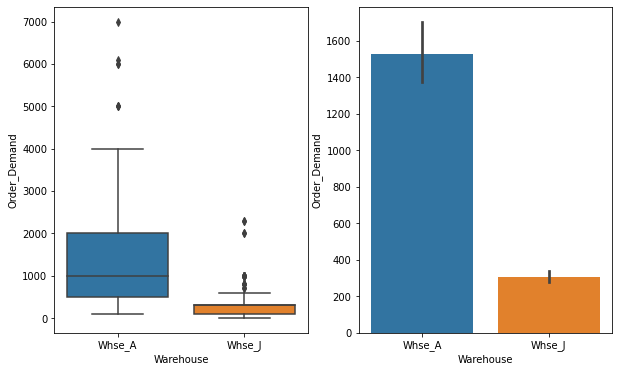

In [12]:
plt.figure(figsize=(10,6)) #창고 종류가 가장 차이가 큰 변수였다.(나머지도 그려봤음)
plt.subplot(121)
sns.boxplot(x="Warehouse",y="Order_Demand",data=Data)
plt.subplot(122)
sns.barplot(x="Warehouse",y="Order_Demand",data=Data)

# 창고별로 데이터 분리하기(각각 예측해서 후에 통합하겠음)

In [13]:
Data_A = Data[Data['Warehouse']=='Whse_A']
Data_J = Data[Data['Warehouse']=='Whse_J']

In [14]:
Data_A.groupby('year_month')['Order_Demand'].mean(),Data_J.groupby('year_month')['Order_Demand'].mean() 
#창고J는 전반적으로 수요값이 평탄하나 창고A는 수요 변동폭이 크다.

(year_month
 2012-01     914.285714
 2012-02    2080.000000
 2012-03    1833.333333
 2012-04     750.000000
 2012-05    2000.000000
 2012-06    2000.000000
 2012-07    2666.666667
 2012-08     800.000000
 2012-09    1120.000000
 2012-10    1712.500000
 2012-11    1500.000000
 2012-12     883.333333
 2013-01    1666.666667
 2013-02    1925.000000
 2013-03    1766.666667
 2013-04    1866.666667
 2013-05     700.000000
 2013-06    1516.666667
 2013-07    1600.000000
 2013-08    1500.000000
 2013-09     883.333333
 2013-10    1880.000000
 2013-11    1375.000000
 2013-12    1500.000000
 2014-01    1366.666667
 2014-02     766.666667
 2014-03    1175.000000
 2014-04    3500.000000
 2014-05    1275.000000
 2014-06    1133.333333
 2014-07    1600.000000
 2014-08    1171.428571
 2014-09    1320.000000
 2014-10    2040.000000
 2014-11    2200.000000
 2014-12    1333.333333
 2015-01    1050.000000
 2015-02    1420.000000
 2015-03    1800.000000
 2015-04    1366.666667
 2015-05    1225.000000
 201

# 분석용 excel Data 생성 및 내보내기

In [15]:
train_A, test_A = Data_A[Data_A['year']!=2016], Data_A[Data_A['year']==2016] # 2012~2015는 train에 2016은 test에 넣겠음.
train_J, test_J = Data_J[Data_J['year']!=2016], Data_J[Data_J['year']==2016] # 2012~2015는 train에 2016은 test에 넣겠음.

In [16]:
train_A.head(), train_J.head()

(   Product_Code Warehouse Product_Category  ...  year  Season  year_month
 2  Product_0001    Whse_A     Category_005  ...  2012       4     2012-01
 3  Product_0001    Whse_A     Category_005  ...  2012       4     2012-01
 4  Product_0001    Whse_A     Category_005  ...  2012       4     2012-01
 6  Product_0001    Whse_A     Category_005  ...  2012       4     2012-01
 7  Product_0001    Whse_A     Category_005  ...  2012       4     2012-01
 
 [5 rows x 10 columns],
     Product_Code Warehouse Product_Category  ...  year  Season  year_month
 5   Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
 8   Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
 9   Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
 11  Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
 12  Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
 
 [5 rows x 10 columns])

In [17]:
grouped_Data_A = train_A.groupby('year_month')['Order_Demand'].sum()
grouped_Data_J = train_J.groupby('year_month')['Order_Demand'].sum()

grouped_Data_A.describe(),grouped_Data_J.describe()

(count       48.000000
 mean      6033.333333
 std       3016.079838
 min       1000.000000
 25%       3900.000000
 50%       5600.000000
 75%       8000.000000
 max      13700.000000
 Name: Order_Demand, dtype: float64, count      48.000000
 mean     1922.916667
 std      1095.491648
 min       500.000000
 25%      1100.000000
 50%      1600.000000
 75%      2625.000000
 max      5300.000000
 Name: Order_Demand, dtype: float64)

# 창고별 시각화

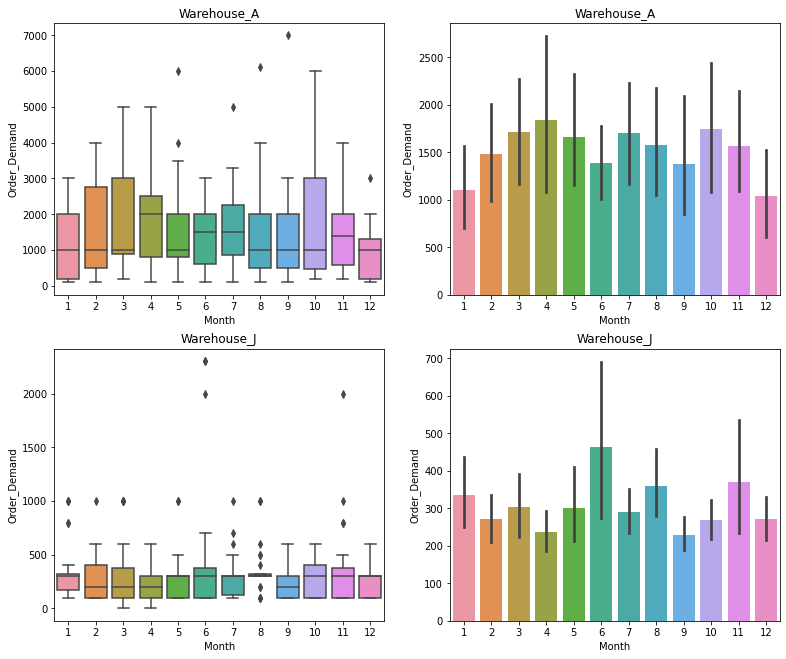

In [18]:
plt.figure(figsize=(13,11))
plt.subplot(221)
plt.title("Warehouse_A")
sns.boxplot(x="Month",y="Order_Demand",data=Data_A)
plt.subplot(222)
plt.title("Warehouse_A")
sns.barplot(x="Month",y="Order_Demand",data=Data_A)
plt.subplot(223)
plt.title("Warehouse_J")
sns.boxplot(x="Month",y="Order_Demand",data=Data_J)
plt.subplot(224)
plt.title("Warehouse_J")
sns.barplot(x="Month",y="Order_Demand",data=Data_J)

# boxplot에서 많이 벗어난 값 제거(월별 plot 기준)

In [19]:
from collections import Counter # Outlier 제거 함수.
def detect_outliers(df, n, features): 
  outlier_indices = [] 
  for col in features:
     Q1 = np.percentile(df[col], 25) 
     Q3 = np.percentile(df[col], 75) 
     IQR = Q3 - Q1 
     outlier_step = 1.5 * IQR 
     outlier_list = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
     outlier_indices.extend(outlier_list)
  return outlier_indices


In [20]:
# 2016년은 제거되면 안되므로, train기간 2012~2015에 대해서만 탐지 및 제거하겠다.
Outliers_to_drop = detect_outliers(train_A, 2, ["Order_Demand"])
print(train_A.loc[Outliers_to_drop]) #이상치 출력 및 바로 제거
train_A = train_A.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

     Product_Code Warehouse Product_Category  ...  year  Season  year_month
35   Product_0001    Whse_A     Category_005  ...  2012       1     2012-03
67   Product_0001    Whse_A     Category_005  ...  2012       2     2012-07
289  Product_0001    Whse_A     Category_005  ...  2014       1     2014-04
365  Product_0001    Whse_A     Category_005  ...  2014       3     2014-10
474  Product_0001    Whse_A     Category_005  ...  2015       3     2015-09

[5 rows x 10 columns]


In [21]:
Outliers_to_drop = detect_outliers(train_J, 2, ["Order_Demand"])
print(train_J.loc[Outliers_to_drop]) #이상치 출력 및 바로 제거
train_J = train_J.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

     Product_Code Warehouse Product_Category  ...  year  Season  year_month
14   Product_0001    Whse_J     Category_005  ...  2012       4     2012-01
32   Product_0001    Whse_J     Category_005  ...  2012       1     2012-03
65   Product_0001    Whse_J     Category_005  ...  2012       2     2012-06
84   Product_0001    Whse_J     Category_005  ...  2012       2     2012-08
128  Product_0001    Whse_J     Category_005  ...  2012       3     2012-11
144  Product_0001    Whse_J     Category_005  ...  2013       4     2013-01
163  Product_0001    Whse_J     Category_005  ...  2013       1     2013-03
206  Product_0001    Whse_J     Category_005  ...  2013       2     2013-07
213  Product_0001    Whse_J     Category_005  ...  2013       2     2013-08
263  Product_0001    Whse_J     Category_005  ...  2014       4     2014-01
272  Product_0001    Whse_J     Category_005  ...  2014       4     2014-02
300  Product_0001    Whse_J     Category_005  ...  2014       1     2014-05
303  Product

In [22]:
Data_A.to_excel("handed_Data_A.xlsx") #파일 내보내기 
Data_J.to_excel("handed_Data_J.xlsx") 

In [25]:
grouped_train_A = train_A.groupby('year_month')['Order_Demand'].sum()
grouped_train_J = train_J.groupby('year_month')['Order_Demand'].sum()

grouped_train_A.describe(),grouped_train_J.describe()

(count       48.000000
 mean      5450.000000
 std       2970.349933
 min       1000.000000
 25%       3000.000000
 50%       5200.000000
 75%       6875.000000
 max      13700.000000
 Name: Order_Demand, dtype: float64, count      48.000000
 mean     1493.750000
 std       782.632288
 min       200.000000
 25%       900.000000
 50%      1400.000000
 75%      2000.000000
 max      3700.000000
 Name: Order_Demand, dtype: float64)

# 실험용 코드 미리 짜놓기(머신러닝 기법이 통할까?)

# train,test 전처리

In [ ]:
# 어느 창고인가의 유무에 따라 1 또는 0의 이진변수로 전환
train_x['Warehouse'] = np.where(train_x['Warehouse']=='Whse_A',1,0)
test_x['Warehouse'] = np.where(test_x['Warehouse']=='Whse_J',1,0)

In [ ]:
train_x

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor(max_depth=5)
model

In [ ]:
feature_names=['Warehouse','Day','Month','Season']
label = 'Order_Demand'

In [ ]:
X_train = train_x[feature_names]
X_test = test_x[feature_names]

In [ ]:
y_train = train[label]
y_test = test[label]

In [ ]:
model.fit(X_train,y_train) 

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
dot_tree=export_graphviz(model,feature_names=feature_names,out_file=None)

In [ ]:
graphviz.Source(dot_tree)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predictions = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test,predictions)

In [ ]:
mape